# Service optimization

In [9]:
import geopandas as gpd

blocks = gpd.read_parquet('./../data/blocks.parquet')
columns = [c for c in blocks.columns if 'capacity_' in c]
blocks = blocks[['geometry', 'population', 'site_area', *columns]].copy()
blocks.head(3)

,geometry,population,site_area,capacity_convenience,capacity_cafe,capacity_mall,capacity_pharmacy,capacity_bank,capacity_fuel,capacity_pitch,...,capacity_bus_station,capacity_bus_stop,capacity_pier,capacity_animal_shelter,capacity_military_kom,capacity_prison,capacity_landfill,capacity_plant_nursery,capacity_greenhouse_complex,capacity_warehouse
id,,,,,,,,,,,,,,,,,,,,,
0,"POLYGON ((354918.622 6625258.829, 354901.464 6...",606,804466.712114,208.0,406.0,2216.0,474.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,"POLYGON ((355412.142 6623378.149, 355411.7 662...",41,23173.129862,811.0,0.0,0.0,0.0,148.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,"POLYGON ((353934.329 6625429.433, 353923.453 6...",14,363005.815802,0.0,0.0,0.0,0.0,0.0,501.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
import pandas as pd

accessibility_matrix = pd.read_pickle('./../accessibility_matrix.pickle')
accessibility_matrix.head()

/home/mark/Documents/Job/City_Optimizer/general/.venv/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,0,1,2,3,4,5,6,7,8,9,...,16310,16311,16312,16313,16314,16315,16316,16317,16318,16319
0,0.000000,18.718750,9.234375,17.21875,30.296875,27.390625,30.671875,23.281250,78.6875,81.2500,...,76.5625,102.5625,97.5000,132.250,130.8750,142.125,247.625,228.625,247.625,124.6250
1,17.859375,0.000000,19.015625,7.65625,20.281250,25.250000,25.234375,15.765625,76.8750,79.4375,...,74.6875,100.7500,95.6875,130.500,129.0000,140.250,245.875,226.875,245.875,112.5000
2,9.234375,20.796875,0.000000,20.21875,27.968750,25.062500,28.343750,20.953125,71.8750,74.4375,...,69.7500,95.8125,90.6875,125.500,124.0625,135.375,240.875,221.875,240.875,124.6250
3,15.937500,7.449219,18.421875,0.00000,21.109375,24.984375,27.781250,16.593750,76.3125,78.8125,...,74.1250,100.1875,95.0625,129.875,128.5000,139.750,245.250,226.250,245.250,113.3750
4,31.906250,19.765625,31.734375,21.28125,0.000000,21.781250,23.125000,15.429688,89.5625,92.1250,...,87.4375,113.5000,108.3750,143.125,141.7500,153.000,258.500,239.500,258.500,108.3125


### Select ID of optimized blocks

In [11]:
from blocksnet.enums import LandUse
blocks_lu = {
    1536 : LandUse.RESIDENTIAL
}

### Service distribution

In [12]:
basic_services = [
    "kindergarten",
    "school",
    "pharmacy",
    "market",
    "cafe",
    "playground",
    "post",
    "hairdresser",
    "bus_stop",
    "parking",
]
advanced_services = [
    "polyclinics",
    "hospital",
    "supermarket",
    "restaurant",
    "park",
    "convenience",
    "bank",
    "fuel",
    "police",
]
comfort_services = ["mall", "dog_park", "swimming_pool", "train_station"]


def get_service_weight(service_name):
    if service_name in basic_services:
        return 0.5714
    elif service_name in advanced_services:
        return 0.2857
    elif service_name in comfort_services:
        return 0.1429
    return 0

### Service types and weights

In [13]:
chosen_service_types = set(basic_services) | set(advanced_services) | set(comfort_services)
service_weights = {service_type: get_service_weight(service_type) for service_type in chosen_service_types if f'capacity_{service_type}' in blocks.columns}

### Initialize and run optimizer

In [14]:
from blocksnet.optimization.services import (
    TPEOptimizer,
    WeightedObjective,
    WeightedConstraints,
    BlocksNetFacade,
    GradientChooser,
)

facade = BlocksNetFacade(
    blocks_lu=blocks_lu,
    blocks_df=blocks,
    accessibility_matrix=accessibility_matrix,
    service_weights=service_weights,
)

objective = WeightedObjective(num_params=facade.num_params, facade=facade, weights=service_weights, max_evals=50)

constraints = WeightedConstraints(num_params=facade.num_params, facade=facade)

tpe_optimizer = TPEOptimizer(
    objective=objective, constraints=constraints, vars_chooser=GradientChooser(facade, facade.num_params, 5)
)

best_x, best_val, perc, func_evals = tpe_optimizer.run(max_runs=1000, timeout=60000, initial_runs_num=1)

100%|██████████| 22/22 [04:53<00:00, 13.32s/it]
[I 2025-04-08 17:58:54,298] A new study created in memory with name: no-name-a01e4dd3-b3b9-49c8-82b5-cd284e49d5c1


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/mark/Documents/Job/City_Optimizer/general/.venv/lib/python3.12/site-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `int` - serialized value may not be as expected [input_value=np.int64(1), input_type=int64])
  return self.__pydantic_serializer__.to_python(
/home/mark/Documents/Job/City_Optimizer/general/.venv/lib/python3.12/site-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `int` - serialized value may not be as expected [input_value=np.int64(0), input_type=int64])
  return self.__pydantic_serializer__.to_python(
2025-04-08 17:58:54.313 | INFO     | blocksnet.analysis.provision.competivive.core:_initialize_provision_df:32 - Initializing provision DataFrame
2025-04-08 17:58:54.319 | INFO     | blocksnet.analysis.provision.competivive.core:_supply_self:59 - Supplying blocks with own capacities
2025-04-08 17:58:54.322 | INFO     | blo

[I 2025-04-08 17:59:05,800] Trial 0 finished with value: 4.212836768128978 and parameters: {'x_0': 0, 'x_1': 0, 'x_2': 0, 'x_3': 0, 'x_4': 0, 'x_5': 0, 'x_6': 0, 'x_7': 0, 'x_8': 0, 'x_9': 0, 'x_10': 0, 'x_11': 0, 'x_12': 0, 'x_13': 0, 'x_14': 0, 'x_15': 0, 'x_16': 0, 'x_17': 0, 'x_18': 0, 'x_19': 0, 'x_20': 0, 'x_21': 0, 'x_22': 0, 'x_23': 0, 'x_24': 0, 'x_25': 0, 'x_26': 0, 'x_27': 0, 'x_28': 0, 'x_29': 0, 'x_30': 0, 'x_31': 0, 'x_32': 0, 'x_33': 0, 'x_34': 0, 'x_35': 0, 'x_36': 0, 'x_37': 0, 'x_38': 0, 'x_39': 0, 'x_40': 0, 'x_41': 0, 'x_42': 0, 'x_43': 0, 'x_44': 0, 'x_45': 0, 'x_46': 0, 'x_47': 0, 'x_48': 0, 'x_49': 0, 'x_50': 0, 'x_51': 0, 'x_52': 0, 'x_53': 0, 'x_54': 0, 'x_55': 0, 'x_56': 0, 'x_57': 0, 'x_58': 0, 'x_59': 0, 'x_60': 0, 'x_61': 0, 'x_62': 0, 'x_63': 0}. Best is trial 0 with value: 4.212836768128978.


/home/mark/Documents/Job/City_Optimizer/general/.venv/lib/python3.12/site-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `int` - serialized value may not be as expected [input_value=np.int64(1), input_type=int64])
  return self.__pydantic_serializer__.to_python(
/home/mark/Documents/Job/City_Optimizer/general/.venv/lib/python3.12/site-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `int` - serialized value may not be as expected [input_value=np.int64(0), input_type=int64])
  return self.__pydantic_serializer__.to_python(


[I 2025-04-08 17:59:06,011] Trial 1 finished with value: 4.212836768128977 and parameters: {'x_0': 0, 'x_1': 0, 'x_2': 0, 'x_4': 0, 'x_5': 0, 'x_6': 0, 'x_7': 0, 'x_8': 0, 'x_9': 0, 'x_10': 0, 'x_11': 0, 'x_12': 0, 'x_25': 0, 'x_26': 0, 'x_27': 0, 'x_29': 0, 'x_30': 0, 'x_31': 0, 'x_32': 0, 'x_33': 0, 'x_34': 0, 'x_35': 0, 'x_56': 0, 'x_57': 0, 'x_58': 0, 'x_59': 0, 'x_60': 0}. Best is trial 0 with value: 4.212836768128978.
[I 2025-04-08 17:59:06,226] Trial 2 pruned. 
[I 2025-04-08 17:59:06,454] Trial 3 pruned. 
[I 2025-04-08 17:59:06,689] Trial 4 pruned. 
[I 2025-04-08 17:59:06,924] Trial 5 pruned. 
[I 2025-04-08 17:59:07,176] Trial 6 pruned. 
[I 2025-04-08 17:59:07,450] Trial 7 pruned. 
[I 2025-04-08 17:59:07,729] Trial 8 pruned. 
[I 2025-04-08 17:59:08,009] Trial 9 pruned. 
[I 2025-04-08 17:59:08,299] Trial 10 pruned. 
[I 2025-04-08 17:59:08,560] Trial 11 finished with value: 4.212836768128977 and parameters: {'x_0': 0, 'x_1': 0, 'x_2': 0, 'x_4': 0, 'x_5': 0, 'x_6': 0, 'x_7': 0, 'x_

/home/mark/Documents/Job/City_Optimizer/general/.venv/lib/python3.12/site-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `int` - serialized value may not be as expected [input_value=np.int64(2), input_type=int64])
  return self.__pydantic_serializer__.to_python(
/home/mark/Documents/Job/City_Optimizer/general/.venv/lib/python3.12/site-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `int` - serialized value may not be as expected [input_value=np.int64(3), input_type=int64])
  return self.__pydantic_serializer__.to_python(
2025-04-08 17:59:08.798 | INFO     | blocksnet.analysis.provision.competivive.core:_initialize_provision_df:32 - Initializing provision DataFrame
2025-04-08 17:59:08.805 | INFO     | blocksnet.analysis.provision.competivive.core:_supply_self:59 - Supplying blocks with own capacities
2025-04-08 17:59:08.834 | INFO     | blo

[I 2025-04-08 17:59:09,486] Trial 12 finished with value: 4.326961646264956 and parameters: {'x_0': 0, 'x_1': 0, 'x_2': 0, 'x_4': 0, 'x_5': 0, 'x_6': 0, 'x_7': 1, 'x_8': 0, 'x_9': 0, 'x_10': 2, 'x_11': 1, 'x_12': 0, 'x_25': 1, 'x_26': 0, 'x_27': 0, 'x_29': 0, 'x_30': 0, 'x_31': 0, 'x_32': 2, 'x_33': 1, 'x_34': 1, 'x_35': 1, 'x_56': 2, 'x_57': 1, 'x_58': 2, 'x_59': 1, 'x_60': 1}. Best is trial 12 with value: 4.326961646264956.


/home/mark/Documents/Job/City_Optimizer/general/.venv/lib/python3.12/site-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `int` - serialized value may not be as expected [input_value=np.int64(1), input_type=int64])
  return self.__pydantic_serializer__.to_python(
/home/mark/Documents/Job/City_Optimizer/general/.venv/lib/python3.12/site-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `int` - serialized value may not be as expected [input_value=np.int64(0), input_type=int64])
  return self.__pydantic_serializer__.to_python(
/home/mark/Documents/Job/City_Optimizer/general/.venv/lib/python3.12/site-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `int` - serialized value may not be as expected [input_value=np.int64(3), input_type=int64])
  return self.__pydantic_serializer

[I 2025-04-08 17:59:10,485] Trial 13 finished with value: 4.376846079243964 and parameters: {'x_0': 0, 'x_1': 0, 'x_2': 0, 'x_4': 0, 'x_5': 0, 'x_6': 0, 'x_7': 2, 'x_8': 1, 'x_9': 0, 'x_10': 2, 'x_11': 1, 'x_12': 0, 'x_25': 1, 'x_26': 0, 'x_27': 0, 'x_29': 2, 'x_30': 0, 'x_31': 0, 'x_32': 3, 'x_33': 2, 'x_34': 2, 'x_35': 2, 'x_56': 2, 'x_57': 2, 'x_58': 2, 'x_59': 2, 'x_60': 2}. Best is trial 13 with value: 4.376846079243964.
[I 2025-04-08 17:59:10,744] Trial 14 pruned. 
[I 2025-04-08 17:59:11,008] Trial 15 pruned. 
[I 2025-04-08 17:59:11,285] Trial 16 pruned. 
[I 2025-04-08 17:59:11,580] Trial 17 pruned. 
[I 2025-04-08 17:59:11,872] Trial 18 pruned. 
[I 2025-04-08 17:59:12,201] Trial 19 pruned. 
[I 2025-04-08 17:59:12,549] Trial 20 pruned. 


/home/mark/Documents/Job/City_Optimizer/general/.venv/lib/python3.12/site-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `int` - serialized value may not be as expected [input_value=np.int64(1), input_type=int64])
  return self.__pydantic_serializer__.to_python(
/home/mark/Documents/Job/City_Optimizer/general/.venv/lib/python3.12/site-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `int` - serialized value may not be as expected [input_value=np.int64(0), input_type=int64])
  return self.__pydantic_serializer__.to_python(
/home/mark/Documents/Job/City_Optimizer/general/.venv/lib/python3.12/site-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `int` - serialized value may not be as expected [input_value=np.int64(2), input_type=int64])
  return self.__pydantic_serializer

[I 2025-04-08 17:59:13,396] Trial 21 finished with value: 4.399593239601063 and parameters: {'x_0': 0, 'x_1': 0, 'x_2': 0, 'x_4': 0, 'x_5': 0, 'x_6': 0, 'x_7': 1, 'x_8': 0, 'x_9': 0, 'x_10': 1, 'x_11': 0, 'x_12': 0, 'x_25': 0, 'x_26': 0, 'x_27': 0, 'x_29': 0, 'x_30': 0, 'x_31': 0, 'x_32': 1, 'x_33': 1, 'x_34': 1, 'x_35': 1, 'x_56': 1, 'x_57': 1, 'x_58': 1, 'x_59': 1, 'x_60': 1}. Best is trial 21 with value: 4.399593239601063.


/home/mark/Documents/Job/City_Optimizer/general/.venv/lib/python3.12/site-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `int` - serialized value may not be as expected [input_value=np.int64(1), input_type=int64])
  return self.__pydantic_serializer__.to_python(
/home/mark/Documents/Job/City_Optimizer/general/.venv/lib/python3.12/site-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `int` - serialized value may not be as expected [input_value=np.int64(0), input_type=int64])
  return self.__pydantic_serializer__.to_python(
/home/mark/Documents/Job/City_Optimizer/general/.venv/lib/python3.12/site-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `int` - serialized value may not be as expected [input_value=np.int64(2), input_type=int64])
  return self.__pydantic_serializer

[I 2025-04-08 17:59:14,378] Trial 22 finished with value: 4.432345135795448 and parameters: {'x_0': 0, 'x_1': 0, 'x_2': 0, 'x_4': 0, 'x_5': 0, 'x_6': 0, 'x_7': 1, 'x_8': 0, 'x_9': 0, 'x_10': 1, 'x_11': 1, 'x_12': 0, 'x_25': 1, 'x_26': 0, 'x_27': 0, 'x_29': 1, 'x_30': 0, 'x_31': 0, 'x_32': 3, 'x_33': 1, 'x_34': 1, 'x_35': 1, 'x_56': 1, 'x_57': 1, 'x_58': 3, 'x_59': 4, 'x_60': 1}. Best is trial 22 with value: 4.432345135795448.
[I 2025-04-08 17:59:14,700] Trial 23 pruned. 


/home/mark/Documents/Job/City_Optimizer/general/.venv/lib/python3.12/site-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `int` - serialized value may not be as expected [input_value=np.int64(1), input_type=int64])
  return self.__pydantic_serializer__.to_python(
/home/mark/Documents/Job/City_Optimizer/general/.venv/lib/python3.12/site-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `int` - serialized value may not be as expected [input_value=np.int64(0), input_type=int64])
  return self.__pydantic_serializer__.to_python(
/home/mark/Documents/Job/City_Optimizer/general/.venv/lib/python3.12/site-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `int` - serialized value may not be as expected [input_value=np.int64(2), input_type=int64])
  return self.__pydantic_serializer

[I 2025-04-08 17:59:15,670] Trial 24 finished with value: 4.460301210615857 and parameters: {'x_0': 0, 'x_1': 0, 'x_2': 0, 'x_4': 0, 'x_5': 0, 'x_6': 0, 'x_7': 1, 'x_8': 0, 'x_9': 0, 'x_10': 1, 'x_11': 1, 'x_12': 0, 'x_25': 1, 'x_26': 0, 'x_27': 0, 'x_29': 2, 'x_30': 0, 'x_31': 0, 'x_32': 1, 'x_33': 1, 'x_34': 1, 'x_35': 1, 'x_56': 4, 'x_57': 7, 'x_58': 4, 'x_59': 4, 'x_60': 3}. Best is trial 24 with value: 4.460301210615857.
[I 2025-04-08 17:59:15,963] Trial 25 pruned. 
[I 2025-04-08 17:59:16,283] Trial 26 pruned. 
[I 2025-04-08 17:59:16,599] Trial 27 pruned. 
[I 2025-04-08 17:59:16,953] Trial 28 pruned. 


/home/mark/Documents/Job/City_Optimizer/general/.venv/lib/python3.12/site-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `int` - serialized value may not be as expected [input_value=np.int64(1), input_type=int64])
  return self.__pydantic_serializer__.to_python(
/home/mark/Documents/Job/City_Optimizer/general/.venv/lib/python3.12/site-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `int` - serialized value may not be as expected [input_value=np.int64(0), input_type=int64])
  return self.__pydantic_serializer__.to_python(
/home/mark/Documents/Job/City_Optimizer/general/.venv/lib/python3.12/site-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `int` - serialized value may not be as expected [input_value=np.int64(7), input_type=int64])
  return self.__pydantic_serializer

[I 2025-04-08 17:59:17,805] Trial 29 finished with value: 4.465664036796984 and parameters: {'x_0': 0, 'x_1': 0, 'x_2': 0, 'x_4': 0, 'x_5': 0, 'x_6': 0, 'x_7': 6, 'x_8': 0, 'x_9': 0, 'x_10': 0, 'x_11': 0, 'x_12': 0, 'x_25': 0, 'x_26': 0, 'x_27': 0, 'x_29': 0, 'x_30': 0, 'x_31': 0, 'x_32': 1, 'x_33': 0, 'x_34': 0, 'x_35': 0, 'x_56': 1, 'x_57': 4, 'x_58': 1, 'x_59': 6, 'x_60': 3}. Best is trial 29 with value: 4.465664036796984.
[I 2025-04-08 17:59:18,121] Trial 30 pruned. 


/home/mark/Documents/Job/City_Optimizer/general/.venv/lib/python3.12/site-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `int` - serialized value may not be as expected [input_value=np.int64(1), input_type=int64])
  return self.__pydantic_serializer__.to_python(
/home/mark/Documents/Job/City_Optimizer/general/.venv/lib/python3.12/site-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `int` - serialized value may not be as expected [input_value=np.int64(0), input_type=int64])
  return self.__pydantic_serializer__.to_python(
/home/mark/Documents/Job/City_Optimizer/general/.venv/lib/python3.12/site-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `int` - serialized value may not be as expected [input_value=np.int64(7), input_type=int64])
  return self.__pydantic_serializer

[I 2025-04-08 17:59:18,970] Trial 31 finished with value: 4.492525414930667 and parameters: {'x_0': 0, 'x_1': 0, 'x_2': 0, 'x_4': 0, 'x_5': 0, 'x_6': 0, 'x_7': 6, 'x_8': 0, 'x_9': 0, 'x_10': 1, 'x_11': 0, 'x_12': 0, 'x_25': 0, 'x_26': 0, 'x_27': 0, 'x_29': 0, 'x_30': 0, 'x_31': 0, 'x_32': 1, 'x_33': 1, 'x_34': 1, 'x_35': 1, 'x_56': 1, 'x_57': 4, 'x_58': 1, 'x_59': 6, 'x_60': 3}. Best is trial 31 with value: 4.492525414930667.


/home/mark/Documents/Job/City_Optimizer/general/.venv/lib/python3.12/site-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `int` - serialized value may not be as expected [input_value=np.int64(1), input_type=int64])
  return self.__pydantic_serializer__.to_python(
/home/mark/Documents/Job/City_Optimizer/general/.venv/lib/python3.12/site-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `int` - serialized value may not be as expected [input_value=np.int64(0), input_type=int64])
  return self.__pydantic_serializer__.to_python(
/home/mark/Documents/Job/City_Optimizer/general/.venv/lib/python3.12/site-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `int` - serialized value may not be as expected [input_value=np.int64(7), input_type=int64])
  return self.__pydantic_serializer

[I 2025-04-08 17:59:19,337] Trial 32 finished with value: 4.297170250544101 and parameters: {'x_0': 0, 'x_1': 0, 'x_2': 0, 'x_4': 0, 'x_5': 0, 'x_6': 0, 'x_7': 6, 'x_8': 0, 'x_9': 0, 'x_10': 0, 'x_11': 0, 'x_12': 0, 'x_25': 0, 'x_26': 0, 'x_27': 0, 'x_29': 0, 'x_30': 0, 'x_31': 0, 'x_32': 0, 'x_33': 0, 'x_34': 0, 'x_35': 0, 'x_56': 1, 'x_57': 4, 'x_58': 1, 'x_59': 7, 'x_60': 3}. Best is trial 31 with value: 4.492525414930667.


/home/mark/Documents/Job/City_Optimizer/general/.venv/lib/python3.12/site-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `int` - serialized value may not be as expected [input_value=np.int64(1), input_type=int64])
  return self.__pydantic_serializer__.to_python(
/home/mark/Documents/Job/City_Optimizer/general/.venv/lib/python3.12/site-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `int` - serialized value may not be as expected [input_value=np.int64(0), input_type=int64])
  return self.__pydantic_serializer__.to_python(
/home/mark/Documents/Job/City_Optimizer/general/.venv/lib/python3.12/site-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `int` - serialized value may not be as expected [input_value=np.int64(10), input_type=int64])
  return self.__pydantic_serialize

[I 2025-04-08 17:59:20,190] Trial 33 finished with value: 4.501024805243632 and parameters: {'x_0': 0, 'x_1': 0, 'x_2': 0, 'x_4': 0, 'x_5': 0, 'x_6': 0, 'x_7': 9, 'x_8': 0, 'x_9': 0, 'x_10': 0, 'x_11': 0, 'x_12': 0, 'x_25': 0, 'x_26': 0, 'x_27': 0, 'x_29': 0, 'x_30': 0, 'x_31': 0, 'x_32': 1, 'x_33': 0, 'x_34': 0, 'x_35': 0, 'x_56': 0, 'x_57': 6, 'x_58': 3, 'x_59': 6, 'x_60': 4}. Best is trial 33 with value: 4.501024805243632.


/home/mark/Documents/Job/City_Optimizer/general/.venv/lib/python3.12/site-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `int` - serialized value may not be as expected [input_value=np.int64(1), input_type=int64])
  return self.__pydantic_serializer__.to_python(
/home/mark/Documents/Job/City_Optimizer/general/.venv/lib/python3.12/site-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `int` - serialized value may not be as expected [input_value=np.int64(0), input_type=int64])
  return self.__pydantic_serializer__.to_python(
/home/mark/Documents/Job/City_Optimizer/general/.venv/lib/python3.12/site-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `int` - serialized value may not be as expected [input_value=np.int64(10), input_type=int64])
  return self.__pydantic_serialize

[I 2025-04-08 17:59:21,056] Trial 34 finished with value: 4.509503540902131 and parameters: {'x_0': 0, 'x_1': 0, 'x_2': 0, 'x_4': 0, 'x_5': 0, 'x_6': 0, 'x_7': 9, 'x_8': 1, 'x_9': 0, 'x_10': 0, 'x_11': 0, 'x_12': 0, 'x_25': 0, 'x_26': 0, 'x_27': 0, 'x_29': 0, 'x_30': 0, 'x_31': 0, 'x_32': 1, 'x_33': 0, 'x_34': 0, 'x_35': 0, 'x_56': 0, 'x_57': 6, 'x_58': 0, 'x_59': 8, 'x_60': 5}. Best is trial 34 with value: 4.509503540902131.
[I 2025-04-08 17:59:21,385] Trial 35 pruned. 
[I 2025-04-08 17:59:21,720] Trial 36 pruned. 
[I 2025-04-08 17:59:22,060] Trial 37 pruned. 
[I 2025-04-08 17:59:22,412] Trial 38 pruned. 
[I 2025-04-08 17:59:22,795] Trial 39 pruned. 
[I 2025-04-08 17:59:23,216] Trial 40 pruned. 
[I 2025-04-08 17:59:23,834] Trial 41 pruned. 
[I 2025-04-08 17:59:24,260] Trial 42 pruned. 
[I 2025-04-08 17:59:24,731] Trial 43 pruned. 
[I 2025-04-08 17:59:25,218] Trial 44 pruned. 
[I 2025-04-08 17:59:25,713] Trial 45 pruned. 
[I 2025-04-08 17:59:26,243] Trial 46 pruned. 
[I 2025-04-08 17:5

/home/mark/Documents/Job/City_Optimizer/general/.venv/lib/python3.12/site-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `int` - serialized value may not be as expected [input_value=np.int64(1), input_type=int64])
  return self.__pydantic_serializer__.to_python(
/home/mark/Documents/Job/City_Optimizer/general/.venv/lib/python3.12/site-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `int` - serialized value may not be as expected [input_value=np.int64(0), input_type=int64])
  return self.__pydantic_serializer__.to_python(
/home/mark/Documents/Job/City_Optimizer/general/.venv/lib/python3.12/site-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `int` - serialized value may not be as expected [input_value=np.int64(4), input_type=int64])
  return self.__pydantic_serializer

[I 2025-04-08 17:59:29,724] Trial 51 finished with value: 4.542358710368848 and parameters: {'x_0': 0, 'x_1': 0, 'x_2': 0, 'x_4': 0, 'x_5': 0, 'x_6': 0, 'x_7': 3, 'x_8': 0, 'x_9': 0, 'x_10': 1, 'x_11': 1, 'x_12': 0, 'x_25': 1, 'x_26': 0, 'x_27': 0, 'x_29': 1, 'x_30': 0, 'x_31': 0, 'x_32': 3, 'x_33': 1, 'x_34': 1, 'x_35': 1, 'x_56': 1, 'x_57': 0, 'x_58': 3, 'x_59': 4, 'x_60': 2}. Best is trial 51 with value: 4.542358710368848.


In [15]:
import matplotlib.pyplot as plt


def plot_df(df):
    df_called_obj = df.loc[df["called_obj"] == True]

    plt.scatter(df_called_obj["func_evals"], df_called_obj["best_val"], c="red", s=5)

    df_called_obj = pd.concat(
        [pd.DataFrame([[-1, None, 0, 0, None, 0, False, 0]], columns=df_called_obj.columns), df_called_obj]
    )
    plt.plot(
        df_called_obj["func_evals"], df_called_obj["best_val"], label="Best Value (TPE)", color="blue", linewidth=1
    )
    # Добавление точек с цветом в зависимости от 'called_obj'
    # Настройка осей и заголовка
    plt.xlabel("Number of objective evaluation")
    plt.ylabel("Best Value")
    plt.title("Best Value Across Trials")
    plt.legend()
    plt.grid(True)

    # Отображение графика
    plt.show()

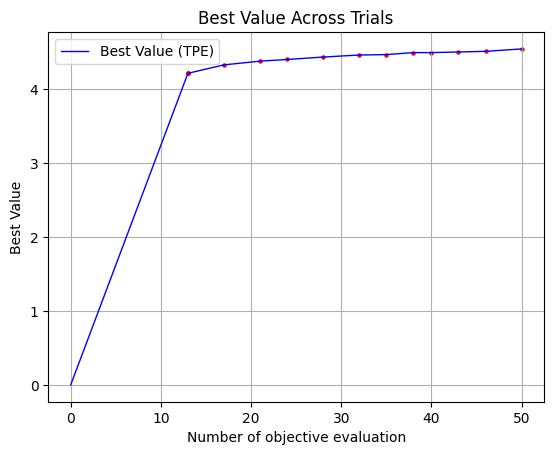

In [16]:
import pandas as pd

tpe_df = pd.read_csv("tpe_trials.csv")
plot_df(tpe_df)

In [17]:
import numpy as np
def save_services(best_x: dict, land_use: LandUse, facade: BlocksNetFacade):
    x = np.zeros(len(facade._converter.X))
    for var_name, var_val in best_x.items():
        x[int(var_name[2:])] = var_val
    X = facade._converter(x)

    # Save placed services
    xs = [
        {
            "block_id": x.block_id,
            "service_type": x.service_type,
            "site_area": x.site_area,
            "build_floor_area": x.build_floor_area,
            "capacity": x.capacity,
            "count": x.count,
        }
        for x in X
    ]
    df = pd.DataFrame(list(xs))
    df[df["count"] != 0].to_csv(f"{land_use.name}_services.csv")

In [18]:
save_services(best_x, blocks_lu[1536], facade)